In [15]:
# Import libraries
import tarfile
import scanpy as sc
import os
import anndata as ad

# ETL Endometriosis

## Extract Data

In [16]:
# Extract files to a directory
data_dir = "/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/data/Endometriosis"
with tarfile.open("data/Endometriosis/GSE214411_RAW.tar", "r") as tar:
    tar.extractall(path="data/Endometriosis")
# List all prefixes (one per sample)
prefixes = [
    "GSM6605431_EMS1_",
    "GSM6605432_EMS2_",
    "GSM6605433_EMS3_",
    "GSM6605434_EMS4_",
    "GSM6605435_EMS5_",
    "GSM6605436_EMS6_",
    "GSM6605437_N1_",
    "GSM6605438_N2_",
    "GSM6605439_N3_",
    "GSM6605440_N4_",
    "GSM7277296_N-5_",
    "GSM7277297_N-6_",
    "GSM7277298_N-7_"
]

adatas = []
for prefix in prefixes:
    adata = sc.read_10x_mtx(
        data_dir,
        prefix=prefix,
        var_names='gene_symbols',
        make_unique=True,
        cache=True
    )
    adata.obs["sample"] = prefix.rstrip("_")
    adatas.append(adata)
# Concatenate all Objects inside adatas into one
adata_endo = ad.concat(adatas, label="batch", keys=[p.rstrip("_") for p in prefixes])

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [17]:
adata_endo

AnnData object with n_obs × n_vars = 155361 × 33694
    obs: 'sample', 'batch'

## Initial EDA: Endometriosis

In [18]:
# Basic filtering: number of genes/cell and number of cells/samples
sc.pp.filter_cells(adata_endo, min_genes=200)
sc.pp.filter_genes(adata_endo, min_cells=3)

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [19]:
# annotate the group of mitochondrial genes as "mt"
adata_endo.var["mt"] = adata_endo.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata_endo, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

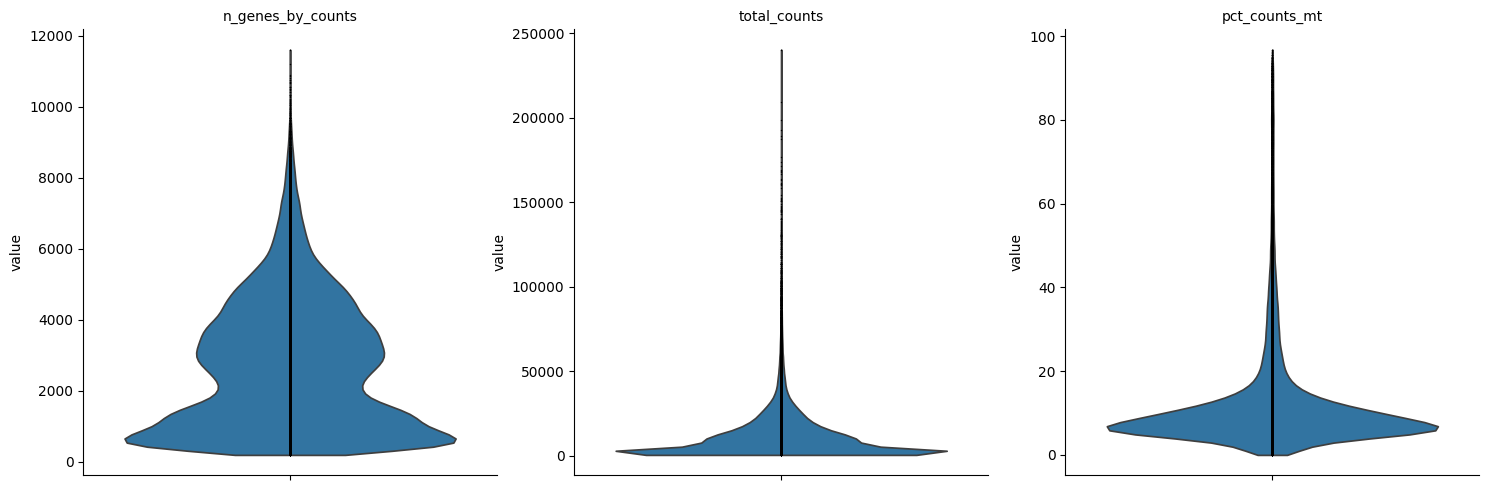

In [20]:
sc.pl.violin(
    adata_endo,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0,
    multi_panel=True,
)

Here we choose to filter out counts > 2500 and mt percent > 20% 

In [21]:
# The actual filtering
adata_endo = adata_endo[adata_endo.obs.n_genes_by_counts < 2500, :]
adata_endo = adata_endo[adata_endo.obs.pct_counts_mt < 20, :].copy()

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [22]:
adata_endo

AnnData object with n_obs × n_vars = 61031 × 28270
    obs: 'sample', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# ETL Ovarian Cancer

## Extract data

In [23]:
# For loop to create an adata for the cancer dataset
# Extract files to a directory
data_dir = "/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/data/Cancer"
with tarfile.open("data/Cancer/GSE184880_RAW.tar", "r") as tar:
    tar.extractall(path="data/Cancer")
# List all prefixes (one per sample)
prefixes = [
    "GSM5599220_Norm1",
    "GSM5599221_Norm2",
    "GSM5599222_Norm3",
    "GSM5599223_Norm4",
    "GSM5599224_Norm5",
    "GSM5599225_Cancer1",
    "GSM5599226_Cancer2",
    "GSM5599227_Cancer3",
    "GSM5599228_Cancer4",
    "GSM5599229_Cancer5",
    "GSM5599230_Cancer6",
    "GSM5599231_Cancer7"
]

adatas = []
for prefix in prefixes:
    # Rename files to match Scanpy's expectations

    os.rename(
        os.path.join(data_dir, f"{prefix}.matrix.mtx.gz"),
        os.path.join(data_dir, f"{prefix}_matrix.mtx.gz")
    )
    os.rename(
        os.path.join(data_dir, f"{prefix}.barcodes.tsv.gz"),
        os.path.join(data_dir, f"{prefix}_barcodes.tsv.gz")
    )
    os.rename(
        os.path.join(data_dir, f"{prefix}.genes.tsv.gz"),
        os.path.join(data_dir, f"{prefix}_features.tsv.gz")
    )
    prefix = prefix + "_" # add underscore 
    adata = sc.read_10x_mtx(
        data_dir,
        prefix=prefix,
        var_names='gene_symbols',
        make_unique=True,
        cache=True
    )
    adata.obs["sample"] = prefix.rstrip("_")
    adatas.append(adata)
# Concatenate all Objects inside adatas into one
adata_cancer = ad.concat(adatas, label="batch", keys=[p.rstrip("_") for p in prefixes])

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [24]:
adata_cancer

AnnData object with n_obs × n_vars = 65820 × 27984
    obs: 'sample', 'batch'

## Initial EDA: Cancer

In [25]:
# Basic filtering: number of genes/cell and number of cells/samples
sc.pp.filter_cells(adata_cancer, min_genes=200)
sc.pp.filter_genes(adata_cancer, min_cells=3)

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [26]:
# annotate the group of mitochondrial genes as "mt"
adata_cancer.var["mt"] = adata_cancer.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata_cancer, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

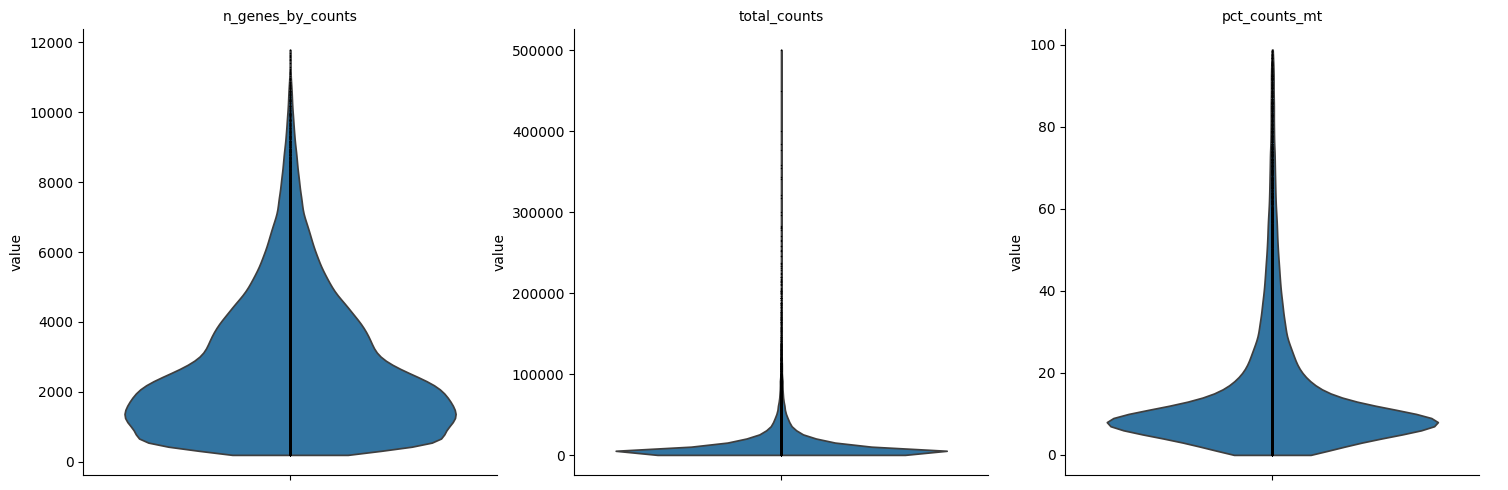

In [27]:
# Explore mt count and gene count 
sc.pl.violin(
    adata_cancer,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0,
    multi_panel=True,
)

Here we choose to filter out counts > 2500 and mt percent > 20% 

In [28]:
# The actual filtering
adata_cancer = adata_cancer[adata_cancer.obs.n_genes_by_counts < 3000, :] # to remove doublets
adata_cancer = adata_cancer[adata_cancer.obs.pct_counts_mt < 20, :].copy() # to remove cells with high mitochondrial activity

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [29]:
adata_cancer

AnnData object with n_obs × n_vars = 32520 × 23219
    obs: 'sample', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt'
    var: 'n_cells', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

# Merging the two datasets without integration

In [17]:
merged_adata = ad.concat(
    [adata_endo, adata_cancer],
    axis=0,          # Concatenate along cells 
    join="inner",    # Keep intersected genes only
    keys=["Endometriosis", "Cancer"],
    merge="unique",  # Handle overlapping metadata uniquely
    index_unique="-",  # Avoid duplicate observation names
    fill_value=0     # Fill missing values wth zeros
)

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1774: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [18]:
merged_adata.X

<Compressed Sparse Row sparse matrix of dtype 'float32'
	with 126819086 stored elements and shape (93551, 18626)>

In [ ]:
# Find highly variable genes
def preprocess(adata):
    # Basic filtering
    sc.pp.filter_cells(adata, min_genes=200)
    sc.pp.filter_genes(adata, min_cells=3)
    # Annotate mito genes and filter them 
    adata.var["mt"] = adata.var_names.str.startswith("MT-")
    sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
    )
    adata = adata[adata.obs.n_genes_by_counts < 2500, :]
    adata = adata[adata.obs.pct_counts_mt < 20, :].copy()
    # Normalize
    sc.pp.normalize_total(adata, target_sum= 1e4)
    # Logarithmize
    sc.pp.log1p(adata)
    # Identify highly variable genes
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    adata = adata[:, adata.var.highly_variable]
    return adata

In [32]:
adata_endo = preprocess(adata_endo)

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [33]:
adata_cancer = preprocess(adata_cancer)

/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/venv1.venv/lib/python3.11/site-packages/anndata/_core/anndata.py:1756: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [2]:
# Loading a parquet file
import pandas as pd
data = pd.read_parquet('/Users/saidalkildani/Desktop/DS_AI/Projects/EndoGyn/data/processed/2025-06-03_103502/df_X_with_target.parquet', engine='pyarrow')

In [5]:
data['target'].unique()

array(['EMS', 'Normal', 'Cancer'], dtype=object)